Load the Model

In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
from torchmetrics.image.fid import FrechetInceptionDistance
import sys

sys.path.append("../")
from src.model.vae_model import VAE
from src.model import unet_model
from src.model.unet_model import Unet
from src.constants import IMAGE_SIZE
from src.data_preparation import dataloader_service
from src.data_preparation.dataloader_service import DeviceDataLoader
from torch.utils.data import DataLoader
import torch


In [9]:
print(DeviceDataLoader.__dict__)

{'__module__': 'src.data_preparation.dataloader_service', '__init__': <function DeviceDataLoader.__init__ at 0x0000023128704E00>, '__iter__': <function DeviceDataLoader.__iter__ at 0x0000023128704EA0>, '__len__': <function DeviceDataLoader.__len__ at 0x0000023128704F40>, '__dict__': <attribute '__dict__' of 'DeviceDataLoader' objects>, '__weakref__': <attribute '__weakref__' of 'DeviceDataLoader' objects>, '__doc__': None}


In [2]:
def set_paramateres():
    IMAGE_SIZE = 128
    LATENT_DIM = 256
    image_dim = IMAGE_SIZE * IMAGE_SIZE * 3
    batch_size = 32
    num_epoch = 10

    return IMAGE_SIZE, LATENT_DIM, image_dim, batch_size, num_epoch


IMAGE_SIZE, LATENT_DIM, image_dim, batch_size, num_epoch = set_paramateres()

def setup_device():
    device = torch.device(
        "cuda"
        if torch.cuda.is_available()
        else "mps" if torch.backends.mps.is_built() else "cpu"
    )
    return device


device = setup_device()

In [3]:
def load_data():
    flowers_train_loader, flowers_test_loader = (
        dataloader_service.get_dataloader(
            dataset_name="Flowers",
            batch_size=batch_size,
            shuffle=True,
            device=device,
            image_size=IMAGE_SIZE,
            baseline=True,
        )
    )

    celeb_train_loader, celeb_test_loader = (
        dataloader_service.get_dataloader(
            dataset_name="CelebA",
            batch_size=batch_size,
            shuffle=True,
            device=device,
            image_size=IMAGE_SIZE,
            baseline=True
        )
    )

    return (
        flowers_train_loader,
        flowers_test_loader,
        celeb_train_loader,
        celeb_test_loader,
    )


(
    flowers_train_loader,
    flowers_test_loader,
    celeb_train_loader,
    celeb_test_loader,
) = load_data()

In [27]:
def create_small_test_loaders(test_loader, sizes=[1, 5, 10, 20]):
    small_test_loaders = {}
    test_dataset = test_loader.get_dataset()
    
    for size in sizes:
        if size > len(test_dataset):
            raise ValueError(f"Requested size {size} exceeds the size of the test dataset ({len(test_dataset)}).")
        
        # Véletlenszerűen kiválasztunk `size` mennyiségű elemet
        indices = torch.randperm(len(test_dataset))[:size]
        subset = torch.utils.data.Subset(test_dataset, indices)
        
        # Létrehozzuk a DataLoader-t a kis halmazhoz
        small_test_loaders[size] = DataLoader(
            subset, batch_size=size, shuffle=False
        )
    
    return small_test_loaders

small_flowers_test_loaders = create_small_test_loaders(flowers_test_loader, sizes=[1, 5, 10, 20])
small_celeba_test_loaders = create_small_test_loaders(celeb_test_loader, sizes=[1, 5, 10, 20])



In [20]:
# Betöltés cpu-ra
device = 'cpu'
model_path_baseline = "../models/flowers/1/vae_model.pth"
model_flowers_baseline = VAE().to(device)
model_flowers_baseline.load_state_dict(torch.load(model_path_baseline, map_location="cpu"))

C:\Users\local_user\AppData\Local\Temp\ipykernel_30228\69686365.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_flowers_baseline.load_state_dict(torch.load(model_p

<All keys matched successfully>

In [21]:
# Betöltés cpu-ra
device = 'cpu'
model_celeba_path_baseline = "../models/celeba/1/celeba_baseline_model.pth"
model_celeba_baseline = VAE().to(device)
model_celeba_baseline.load_state_dict(torch.load(model_celeba_path_baseline, map_location="cpu"))

C:\Users\local_user\AppData\Local\Temp\ipykernel_30228\2005004052.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_celeba_baseline.load_state_dict(torch.load(model_

<All keys matched successfully>

In [22]:
model_flowers_ddpm = Unet(
    dim=64,
    dim_mults=(1, 2, 4)
)

model_path_ddpm = "../models/flowers/2/flowers_model_best.pth"
model_flowers_ddpm.load_state_dict(torch.load(model_path_ddpm, map_location="cpu"))

C:\Users\local_user\AppData\Local\Temp\ipykernel_30228\4259625825.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_flowers_ddpm.load_state_dict(torch.load(model_pat

<All keys matched successfully>

In [23]:
model_celeba_ddpm = Unet(
    dim=64,
    dim_mults=(1, 2, 4)
)

model_celeba_path_ddpm = "../models/celeba/2/celeba_model_best.pth"
model_celeba_ddpm.load_state_dict(torch.load(model_celeba_path_ddpm, map_location="cpu"))

C:\Users\local_user\AppData\Local\Temp\ipykernel_30228\20863571.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_celeba_ddpm.load_state_dict(torch.load(model_celeba

<All keys matched successfully>

Define Fid method

In [26]:
def calculate_fid_score_general(model, test_loader, model_type="vae", timesteps=None, device="cpu"):
    """
    Generalized FID calculation for VAE and U-Net-based models.

    Args:
        model: The generative model (VAE or U-Net).
        test_loader: DataLoader for test images (real images).
        model_type: Type of model, either "vae" or "unet".
        timesteps: Number of diffusion timesteps (required for U-Net).
        device: Device for computation ("cpu" or "cuda").

    Returns:
        FID score as a float.
    """
    # Import required metric
    fid_metric = FrechetInceptionDistance(feature=2048).to(device, dtype=torch.float32)

    model.to(device).eval()

    # Check if timesteps are provided for unet models
    if model_type == "unet" and timesteps is None:
        raise ValueError("For U-Net models, 'timesteps' must be specified.")

    # Precompute diffusion constants for unet
    if model_type == "unet":
        betas = unet_model.linear_beta_schedule(timesteps=timesteps).to(device)
        alphas = 1.0 - betas
        alphas_cumprod = torch.cumprod(alphas, axis=0)
        sqrt_recip_alphas = torch.sqrt(1.0 / alphas).to(device)
        sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod).to(device)

    with torch.no_grad():
        for idx, (images, _) in enumerate(test_loader):
            print(f"Batch: {idx + 1}/{len(test_loader)}", end="\r")

            # Preprocess real images
            real_images = (images * 255).clamp(0, 255).to(torch.uint8).to(device)

            if model_type == "vae":
                # Handle the VAE logic only here
                reconstructed_images = []
                for img in images:
                    img = img.unsqueeze(0).to(device)
                    mu, log_var = model.encode(img)  # VAE encoder
                    z = model.reparameterize(mu, log_var)  # Sampling latent vector
                    reconstructed_img = model.decode(z)  # Decode the latent vector
                    reconstructed_images.append(reconstructed_img.squeeze(0))

                reconstructed_images = (
                    torch.stack(reconstructed_images).mul(255).clamp(0, 255).to(torch.uint8)
                )

            elif model_type == "unet":
                # Handle the U-Net diffusion logic here
                batch_size = images.size(0)
                noise = torch.randn_like(images).to(device)

                # Start with pure noise
                x_t = noise
                for t in reversed(range(timesteps)):
                    t_tensor = torch.full((batch_size,), t, device=device, dtype=torch.long)

                    # Denoise step
                    model_pred = model(x_t, t_tensor)
                    alpha_t = alphas_cumprod[t].to(device)
                    sqrt_alpha_t = torch.sqrt(alpha_t).to(device)
                    sqrt_one_minus_alpha_t = torch.sqrt(1.0 - alpha_t).to(device)

                    # Compute the posterior mean
                    x0_t = (x_t - sqrt_one_minus_alpha_t * model_pred) / sqrt_alpha_t
                    mean = alpha_t * x0_t + (1 - alpha_t) * x_t

                    # Sample from posterior or use deterministic mean
                    if t > 0:
                        x_t = mean + torch.sqrt(1 - alpha_t) * torch.randn_like(x_t).to(device)
                    else:
                        x_t = mean  # Final denoised image

                reconstructed_images = (
                    x_t.mul(255).clamp(0, 255).to(torch.uint8)
                )

            else:
                raise ValueError(f"Unsupported model_type: {model_type}")

            # Update FID metric
            fid_metric.update(real_images, real=True)
            fid_metric.update(reconstructed_images, real=False)

    # Compute and return the FID score
    fid_score = fid_metric.compute()
    return fid_score.item()


Count Fid Score for saved models

Baseline Flower on 5 images

In [29]:
fid_score_flowers = calculate_fid_score_general(model_flowers_baseline, small_flowers_test_loaders[5], model_type="vae")
print(f"FID Score for Besline model of Flowers: {fid_score_flowers}")

FID Score for Besline model of Flowers: 480.8042297363281


Baseline Celeb on 5 images

In [30]:
fid_score_celeba_baseline = calculate_fid_score_general(model_celeba_baseline, small_celeba_test_loaders[5], model_type="vae")
print(f"FID Score for Besline model of Flowers: {fid_score_celeba_baseline}")

FID Score for Besline model of Flowers: 404.7934265136719


DDPM Flower on 5 images

In [31]:
fid_score_flowers_ddpm = calculate_fid_score_general(model_flowers_ddpm, small_flowers_test_loaders[5], model_type="unet", timesteps=300)
print(f"FID Score for Besline model of Flowers: {fid_score_flowers_ddpm}")

FID Score for Besline model of Flowers: 576.6796264648438


DDPM Celeb on 5 images

In [32]:
fid_score_celeba_ddpm = calculate_fid_score_general(model_celeba_ddpm, small_celeba_test_loaders[5], model_type="unet", timesteps=300)
print(f"FID Score for Besline model of Flowers: {fid_score_celeba_ddpm}")

FID Score for Besline model of Flowers: 440.6463928222656


Baseline Flower on 10 images

In [33]:
fid_score_flowers = calculate_fid_score_general(model_flowers_baseline, small_flowers_test_loaders[10], model_type="vae")
print(f"FID Score for Besline model of Flowers: {fid_score_flowers}")

FID Score for Besline model of Flowers: 403.63311767578125


Baseline Celeb on 10 images

In [34]:
fid_score_celeba_baseline = calculate_fid_score_general(model_celeba_baseline, small_celeba_test_loaders[10], model_type="vae")
print(f"FID Score for Besline model of Flowers: {fid_score_celeba_baseline}")

FID Score for Besline model of Flowers: 386.61334228515625


DDPM Flower on 10 images

In [35]:
fid_score_flowers_ddpm = calculate_fid_score_general(model_flowers_ddpm, small_flowers_test_loaders[10], model_type="unet", timesteps=300)
print(f"FID Score for Besline model of Flowers: {fid_score_flowers_ddpm}")

FID Score for Besline model of Flowers: 519.7136840820312


DDPM Celeb on 10 images

In [36]:
fid_score_celeba_ddpm = calculate_fid_score_general(model_celeba_ddpm, small_celeba_test_loaders[10], model_type="unet", timesteps=300)
print(f"FID Score for Besline model of Flowers: {fid_score_celeba_ddpm}")

FID Score for Besline model of Flowers: 408.2311706542969


In [ ]:
import os
import torch
import matplotlib.pyplot as plt
from datetime import datetime


# Konstansok
LATENT_DIM = 256
NUM_IMAGES = 30
OUTPUT_DIR = "results/generated_flower_vae_images"
os.makedirs(OUTPUT_DIR, exist_ok=True)  # Mappa létrehozása, ha nem létezik

# Eszköz beállítása
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Betöltött modell
vae_model = VAE().to(device)
vae_model.load_state_dict(torch.load("../models/flowers/vae_model_2.pth"))  # Töltsd be a mentett modellállapotot
vae_model.eval()

# Képgeneráló függvény
def generate_images(model, num_images, output_dir):
    """Generálj és ments el képeket a megadott modellel."""
    with torch.no_grad():
        latent_samples = torch.randn(num_images, LATENT_DIM).to(device)  # Zaj generálása
        generated_images = model.decode(latent_samples)  # Képgenerálás

    for i in range(num_images):
        image = generated_images[i].cpu().permute(1, 2, 0).numpy()  # Tensor átalakítása
        image = (image * 255).astype("uint8")  # Pixelértékek [0, 255] közé skálázása

        # Mentés fájlba
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S_%f")
        output_path = os.path.join(output_dir, f"generated_image_{timestamp}.png")
        
        plt.imsave(output_path, image)

# 30 kép generálása és mentése
generate_images(vae_model, NUM_IMAGES, OUTPUT_DIR)



C:\Users\local_user\AppData\Local\Temp\ipykernel_30228\3771617701.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae_model.load_state_dict(torch.load("../models/flower

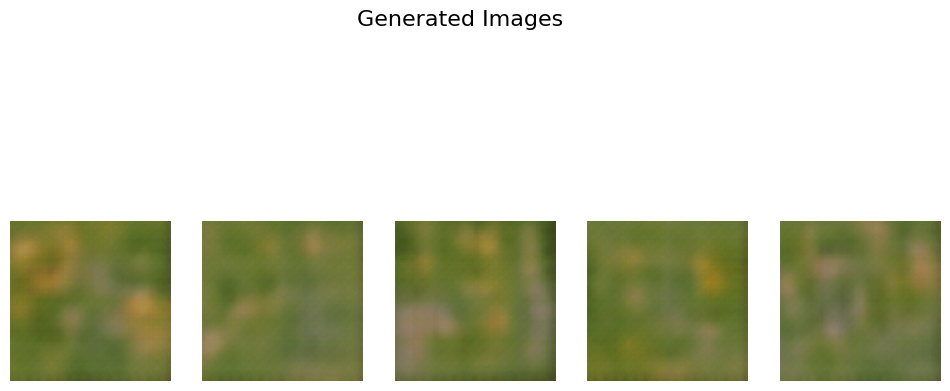

In [46]:
import os
import torch
import numpy as np
from torchvision import transforms, models
from PIL import Image
from scipy.stats import entropy
from torchvision.models import inception_v3


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
inception_model = inception_v3(pretrained=True, transform_input=False).to(device)
inception_model.eval()

def load_images_from_folder(folder, image_size=(64, 64)):
    """
    Betölti az összes képet egy mappából, és átméretezi azokat az adott méretre.
    
    Args:
        folder (str): A mappa elérési útja.
        image_size (tuple): Az új képméret (299, 299 az Inception-hez).
    
    Returns:
        list of torch.Tensor: Az előfeldolgozott képek listája.
        list of PIL.Image: Az eredeti képek listája vizualizációhoz.
    """
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalizálás
    ])
    images = []
    original_images = []
    for filename in os.listdir(folder):
        filepath = os.path.join(folder, filename)
        try:
            with Image.open(filepath).convert("RGB") as img:
                original_images.append(img.copy())  # Mentés megjelenítéshez
                images.append(transform(img))
        except Exception as e:
            print(f"Nem sikerült betölteni a(z) {filepath} képet: {e}")
    return torch.stack(images), original_images


def calculate_inception_score(images, inception_model, splits=10):
    """
    Számítsa ki az Inception Score-t (IS) az adott képek alapján.
    
    Args:
        images (torch.Tensor): A képek tensorja (N, 3, 64, 64).
        inception_model (torch.nn.Module): Az előre betanított Inception modell.
        splits (int): Az IS kiszámításának szakaszai.
    
    Returns:
        float: Az IS átlaga.
        float: Az IS szórása.
    """
    inception_model.eval()
    with torch.no_grad():
        preds = []
        batch_size = 32
        for i in range(0, len(images), batch_size):
            batch = images[i:i + batch_size]
            preds.append(inception_model(batch).softmax(dim=1).cpu().numpy())
        preds = np.concatenate(preds, axis=0)

    N = preds.shape[0]
    split_scores = []

    for k in range(splits):
        part = preds[k * (N // splits): (k + 1) * (N // splits), :]
        py = np.mean(part, axis=0)
        scores = [entropy(pyx, py) for pyx in part]
        split_scores.append(np.exp(np.mean(scores)))

    return np.mean(split_scores), np.std(split_scores)


# Képek betöltése és előfeldolgozása
image_dir = "results/generated_flower_vae_images"
processed_images, original_images = load_images_from_folder(image_dir, image_size=(64, 64))

# # Inception Score kiszámítása
# mean_is, std_is = calculate_inception_score(processed_images, inception_model)
# print(f"Inception Score: {mean_is:.2f} ± {std_is:.2f}")

# Vizualizáció néhány képpel
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for i in range(min(len(original_images), 5)):
    plt.subplot(1, 5, i + 1)
    plt.imshow(original_images[i])
    plt.axis('off')
plt.suptitle("Generated Images", fontsize=16)
plt.show()

In [47]:
inception_model = inception_v3(pretrained=True)
inception_model.transform_input = False
inception_model.Conv2d_1a_3x3.conv = torch.nn.Conv2d(
    in_channels=3,
    out_channels=32,
    kernel_size=(3, 3),
    stride=(1, 1),
    padding=(1, 1),
    bias=False
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
processed_images = processed_images.to(device)
inception_model = inception_model.to(device)

# IS számítása
print("Inception Score számítása...")
is_mean, is_std = calculate_inception_score(processed_images, inception_model, splits=10)
print(f"Inception Score: {is_mean:.2f} ± {is_std:.2f}")


Inception Score számítása...
Inception Score: 1.77 ± 0.20
